In [1]:
from mb.lang.basic import ModelFactory
llm = ModelFactory(model_name="gemini-3.1-pro-preview",model_type='google')
# llm = ModelFactory(model_name="gemini-2.5-pro", model_type='google')

/home/malav/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/malav/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:58: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
from mb.lang.agents.get_langsmith import set_langsmith_parameters
import os
from dotenv import load_dotenv
load_dotenv('./.env')
set_langsmith_parameters(langsmith_endpoint="https://api.smith.langchain.com",
                        langsmith_project="BB-Labeling-Agent-Project",
                        langsmith_tracing="true")
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [3]:
from mb.lang.agents.seg_autolabel import SegmentationGraph,CreateBBAgent
from mb.utils.logging import logger


In [4]:
agent = CreateBBAgent(llm.model,logging=False,langsmith_params=True,logger=logger)
graph_agent = SegmentationGraph(agent,logger=logger)

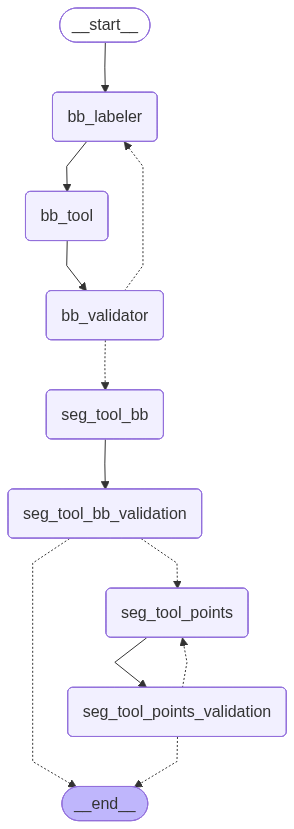

In [5]:
from IPython.display import Image, display
display(Image(graph_agent._build_graph().get_graph(xray=True).draw_mermaid_png()))

In [6]:
graph_agent.run?

Signature:
graph_agent.run(
    image_path: str,
    query: str,
    temp_image: str = './data/temp_bb_image.jpg',
    temp_segm_mask_path: str = './data/temp_seg_image_bb.jpg',
    temp_segm_mask_points_path: str = './data/temp_seg_image_points.jpg',
    sam_model_path: str = './models/sam2_hiera_small.pt',
    sam_model_file_path: str = './models/sam2.1_hiera_small.yaml',
    recursion_limit: int = 25,
    *,
    config=None,
)
Docstring:
Execute the full bounding-box -> segmentation pipeline.

Args:
    image_path: Path to the source image.
    query: The labeling/segmentation prompt.
    temp_image: Path for temporary bounding-box annotated image.
    temp_segm_mask_path: Path for temporary segmentation mask image.
    temp_segm_mask_points_path: Path for temporary segmentation points image.
    sam_model_path: Path to the SAM2 model weights.
    recursion_limit: Maximum graph recursion depth.

Returns:
    Final SegmentationState dict after pipeline completion.
File:      ~/.local

In [7]:
print(os.path.exists('../../sam2_hiera_small.pt'))
print(os.path.exists('../sam2_hiera_s.yaml'))

True
True


06:04:11 │ WARNING  │ Loading default font


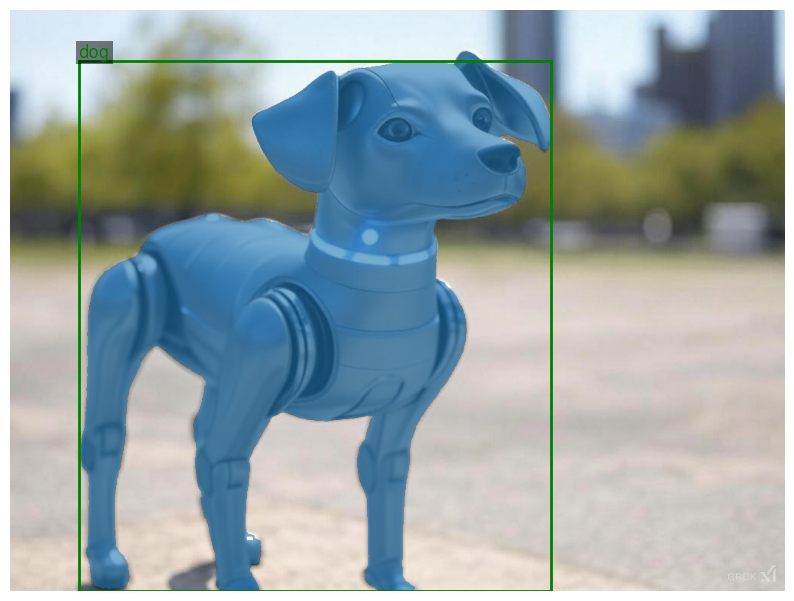

{'messages': [{'role': 'agent',
   'content': '{\n  "labeled_objects": [\n    {"label": "dog", "box": [0.088, 0.088, 0.697, 1.0], "valid": false}\n  ]\n}'}],
 'labeled_objects': [{'label': 'dog',
   'box': [0.088, 0.088, 0.697, 1.0],
   'valid': True}],
 'temp_bb_img_path': '../data/temp_image.jpg',
 'temp_segm_mask_path': '../data/temp_seg_image_bb.jpg',
 'temp_segm_mask_points_path': '../data/temp_seg_image_points.jpg',
 'positive_points': [],
 'negative_points': [],
 'bbox_json_reason': [],
 'bbox_json': '{"labeled_objects": [{"label": "dog", "box": [0.088, 0.088, 0.697, 1.0], "valid": true}]}',
 'bb_valid': True,
 'seg_validation_reason': '',
 'seg_valid': True,
 'query': 'Create a bounding box around dog in the image.',
 'image_path': '../data/image.jpg',
 'failed_labels': None,
 'failed_segmentation': [],
 'sam_model_path': '/home/malav/Desktop/segment-anything-2/checkpoints/sam2_hiera_small.pt',
 'sam_model_file_path': '//home/malav/Desktop/segment-anything-2/sam2_configs/sam2_h

In [9]:
graph_agent.run(image_path='../data/image.jpg', 
                temp_image='../data/temp_image.jpg',
                temp_segm_mask_path='../data/temp_seg_image_bb.jpg',
                temp_segm_mask_points_path='../data/temp_seg_image_points.jpg',
                sam_model_path = '/home/malav/Desktop/segment-anything-2/checkpoints/sam2_hiera_small.pt',
                sam_model_file_path = '//home/malav/Desktop/segment-anything-2/sam2_configs/sam2_hiera_s.yaml',
                query="Create a bounding box around dog in the image.",
                recursion_limit=25) ## min. atleast 9 needed.

In [9]:
from mb_rag.utils.extra import ImagePredictor

In [10]:
a = ImagePredictor('./sam2_hiera_s.yaml','/home/malav/Desktop/segment-anything-2/checkpoints/sam2_hiera_small.pt')

In [12]:
a.set_image('../data/temp_image.jpg')

In [13]:
a.image.shape

(768, 1024, 3)

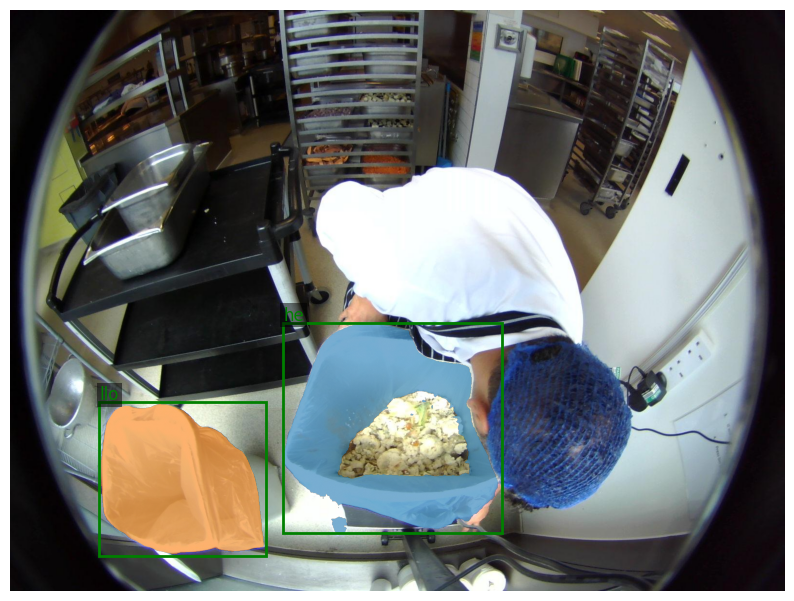

In [11]:
mask,_,_ =a.predict_item(bbox=[[645.6, 563.1999999999999, 1080.0, 1016.0],[810.0, 184.0, 1128.0, 528.0]],labels_names=['he','llo']) 


In [12]:
mask.shape

(2, 1200, 1600)

(1, 1200, 1600)


(-0.5, 1599.5, 1199.5, -0.5)

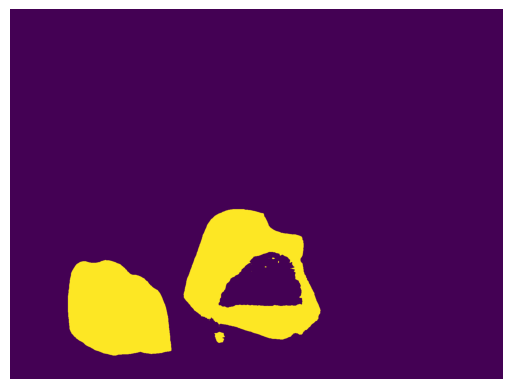

In [13]:
import matplotlib.pyplot as plt
import numpy as np

mask = mask.sum(axis=0)
mask = np.expand_dims(mask, axis=0)
print(mask.shape)
mask_new = np.transpose(mask, (1, 2, 0))
plt.imshow(mask_new)
plt.axis('off')